In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)




def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

def create_model():
    autoencoder = Autoencoder().to(device)
    print_model(autoencoder.encoder, autoencoder.decoder)
    if device.type == 'cuda':
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# Custom round function
class RoundWithGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.sign(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def round_with_gradient(x):
    return RoundWithGradient.apply(x)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(48*4*4, 1000),   # Flatten 48 channels of 4x4 image into 1000 latent dimensions
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1000, 48*4*4),  # Take in 1000 latent dimensions and transform to 48*4*4
            nn.ReLU(),
            nn.Unflatten(1, (48, 4, 4)),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.round_with_gradient(encoded)  # Assuming this function is defined elsewhere
        decoded = self.decoder(encoded)
        return encoded, decoded

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# To perform validation only, set valid=True
valid = False

autoencoder = create_model()

if valid:
    print("Loading checkpoint...")
    autoencoder.load_state_dict(torch.load("./weights/autoencoder.pkl"))
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
    imshow(torchvision.utils.make_grid(images))

    images = images.to(device)
    decoded_imgs = autoencoder(images)[1]
    imshow(torchvision.utils.make_grid(decoded_imgs.data))

else:
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters())

    for epoch in range(500):
        running_loss = 0.0
        for i, (inputs, _) in enumerate(trainloader, 0):
            inputs = inputs.to(device)
            encoded, outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    print('Saving Model...')
    if not os.path.exists('./weights'):
        os.mkdir('./weights')
    torch.save(autoencoder.state_dict(), "./weights/autoencoder.pkl")


Files already downloaded and verified
Files already downloaded and verified
============== Encoder ==============
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=768, out_features=800, bias=True)
  (8): Tanh()
)
============== Decoder ==============
Sequential(
  (0): Linear(in_features=800, out_features=768, bias=True)
  (1): ReLU()
  (2): Unflatten(dim=1, unflattened_size=(48, 4, 4))
  (3): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (8): Sigmoid()
)

Model moved to GPU in order 

Loading checkpoint...
GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


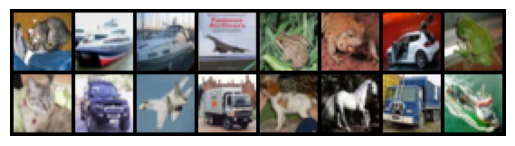

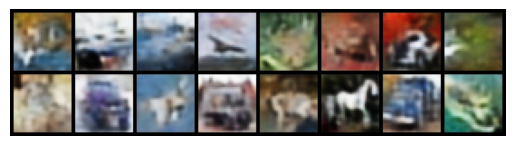

In [27]:
print("Loading checkpoint...")
autoencoder.load_state_dict(torch.load("./weights/autoencoder.pkl"))

images, labels = next(iter(testloader))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)
decoded_imgs = autoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [36]:
x = autoencoder.encoder(images)
encoded = round_with_gradient(x)
encoded.shape

torch.Size([16, 800])